<a href="https://colab.research.google.com/github/Jacqueline45/EE559_Project/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
!unzip /content/EE559_Project-main.zip


Archive:  /content/EE559_Project-main.zip
cd4e0a51e0b87e7bb5bd032f2efedcc9a0da1845
replace EE559_Project-main/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [59]:
import pandas as pd 
import imblearn
import numpy as np 

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generates all performance measures

def metrics(true_labels, pred_labels, plot_title, work='test'):
    cf_matrix = confusion_matrix(true_labels, pred_labels)
    TP, TN, FP, FN = cf_matrix[1][1], cf_matrix[0][0], cf_matrix[0][1], cf_matrix[1][0]
    Recall = TP/(TP+FN)
    Precision = TP/(TP+FP)
    F1_score = 2*Recall*Precision/(Recall+Precision)
    Accuracy = (TP+TN)/true_labels.shape[0]
    
    if work == 'test':
        ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

        ax.set_title(plot_title)
        ax.set_xlabel('Predicted Values')
        ax.set_ylabel('Actual Values ')

        ax.xaxis.set_ticklabels(['0','1'])
        ax.yaxis.set_ticklabels(['0','1'])

        plt.savefig('/content/EE559_Project-main/cf_matrix_plots/'+plot_title+'.png')

        return F1_score, Accuracy

    else:
        return F1_score, Accuracy, TP, TN, FP, FN

def plot_val_cf_matrix(true_labels, pred_labels, plot_title, TP, TN, FP, FN):
    cf_matrix = confusion_matrix(true_labels, pred_labels)
    cf_matrix[1][1], cf_matrix[0][0], cf_matrix[0][1], cf_matrix[1][0] = TP, TN, FP, FN
    
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_title(plot_title)
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values ')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])

    plt.savefig('/content/EE559_Project-main/cf_matrix_plot/'+plot_title+'_val.png')

In [61]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

fires_train = pd.read_csv("/content/EE559_Project-main/datasets/algerian_fires_train.csv")
fires_test = pd.read_csv("/content/EE559_Project-main/datasets/algerian_fires_test.csv")

data = fires_train.describe()
tstdata = fires_test.describe()

fires_train = fires_train.iloc[:,1:]
fires_test = fires_test.iloc[:,1:]


##Normalising the data as there is scale difference
predictors = fires_train.iloc[:,:-1]
target = fires_train.iloc[:,-1:]

predictorstst = fires_test.iloc[:,:-1]
targettst = fires_test.iloc[:,-1:]

scalar = MinMaxScaler()

fires = scalar.fit_transform(predictors)
firestst = scalar.fit_transform(predictorstst)

x_train,x_test,y_train,y_test = train_test_split(predictors,target, stratify = target)

X_train,X_test,Y_train,Y_test = train_test_split(predictorstst,targettst, stratify = targettst)


model_linear = SVC(kernel = "linear")
model_linear.fit(x_train,y_train)
pred_test_linear = model_linear.predict(x_test)

#test

model_linear1 = SVC(kernel = "linear")
model_linear1.fit(X_train,Y_train)
pred_test_linear1 = model_linear1.predict(X_test)

# kernel = rbf
model_rbf = SVC(kernel = "rbf")
model_rbf.fit(x_train,y_train)
pred_test_rbf = model_rbf.predict(x_test)

#test rbf
model_rbf1 = SVC(kernel = "rbf")
model_rbf1.fit(x_train,y_train)
pred_test_rbf1 = model_rbf1.predict(X_test)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [62]:
from sklearn.metrics import accuracy_score
p = accuracy_score(y_test,pred_test_linear)
q = accuracy_score(y_test,pred_test_rbf)
r = accuracy_score(Y_test,pred_test_linear1)
s = accuracy_score(Y_test,pred_test_rbf1)

print("Train Linear Accuracy=", p, "Train RBF Accuracy=", q, "Test Linear Accuracy=", r, "Test RBF Accuracy=", s)

Train Linear Accuracy= 0.9130434782608695 Train RBF Accuracy= 0.8260869565217391 Test Linear Accuracy= 0.8666666666666667 Test RBF Accuracy= 0.8666666666666667


Train F1_score= 0.9285714285714286 Train Accuracy= 0.9130434782608695


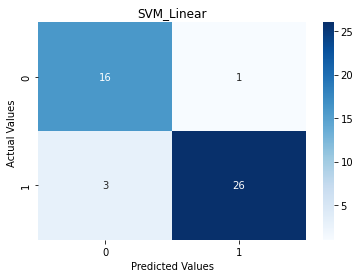

In [63]:
F1_score, Accuracy = metrics(y_test, pred_test_linear, "SVM_Linear")
print("Train F1_score=", F1_score, "Train Accuracy=", Accuracy)

Train RBF F1_score= 0.8666666666666666 Train RBF Accuracy= 0.8260869565217391


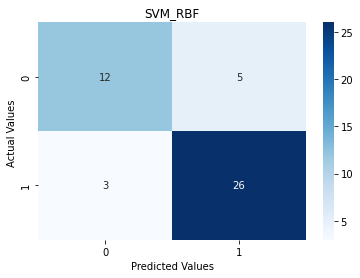

In [64]:
F1_score, Accuracy = metrics(y_test, pred_test_rbf, "SVM_RBF")
print("Train RBF F1_score=", F1_score, "Train RBF Accuracy=", Accuracy)

Test F1_score= 0.8333333333333334 Test Accuracy= 0.8666666666666667


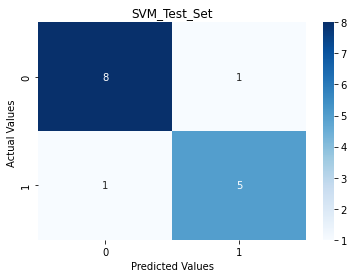

In [65]:
F1_score, Accuracy = metrics(Y_test, pred_test_linear1, "SVM_Test_Set")
print("Test F1_score=", F1_score, "Test Accuracy=", Accuracy)

Test RBF F1_score= 0.8333333333333334 Test RBF Accuracy= 0.8666666666666667


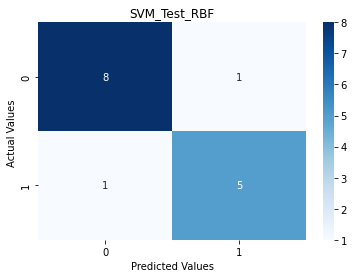

In [66]:
F1_score, Accuracy = metrics(Y_test, pred_test_rbf1, "SVM_Test_RBF")
print("Test RBF F1_score=", F1_score, "Test RBF Accuracy=", Accuracy)